## Project Overview

This notebook analyses mortality outcomes in individuals with schizophrenia and intellectual disabilities using machine learning models. The analysis includes data preprocessing, model training (Logistic Regression, Random Forest, XGBoost, SVM), evaluation metrics, and SHAP-based model interpretation.

## Model Training and Evaluation

Training machine learning models and evaluating their performance using metrics like ROC AUC, confusion matrix, and classification reports.

## Cross-Validation and Final Insights

Applying cross-validation and summarising model robustness.

In [29]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import shap

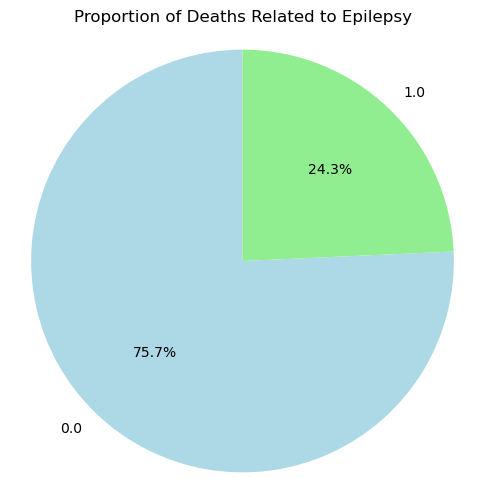

In [40]:
import matplotlib.pyplot as plt

# Assuming 'death_epilepsy' is a binary column indicating death related to epilepsy (1.0) or not (0.0)
# Calculate the proportion of each category (1.0 for death related to epilepsy and 0.0 for others)
death_epilepsy_counts = df_cleaned['death_epilepsy'].value_counts(normalize=True)

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(death_epilepsy_counts, labels=death_epilepsy_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen'])
plt.title('Proportion of Deaths Related to Epilepsy')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.
plt.show()


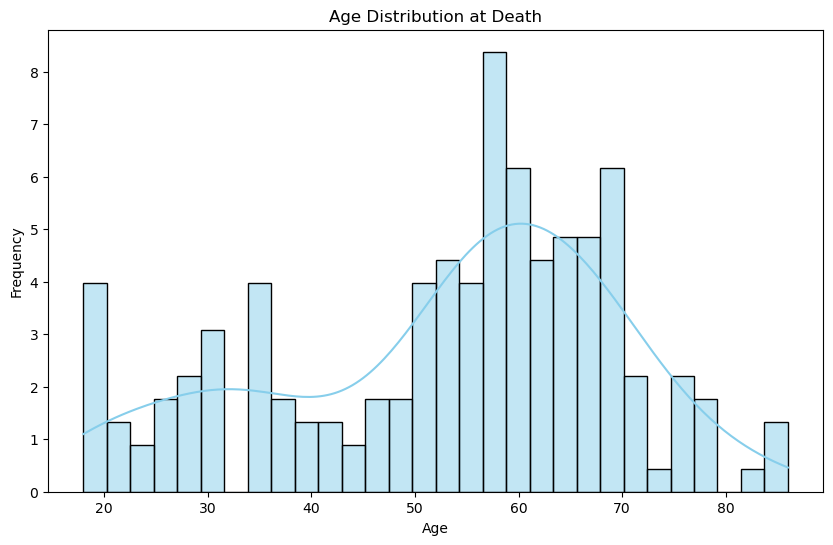

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'age_at_death' is the column in your dataset representing the ages at which individuals died
# Replace 'age_at_death' with the actual column name in your DataFrame

# Check if 'age_at_death' column exists
if 'death_age' in df_cleaned.columns:
    # Plot the histogram with KDE
    plt.figure(figsize=(10, 6))
    sns.histplot(df_cleaned['death_age'], bins=30, kde=True, color='skyblue', stat='frequency')

    # Set the title and labels
    plt.title('Age Distribution at Death')
    plt.xlabel('Age')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()
else:
    print("The column 'age_at_death' does not exist in the DataFrame.")


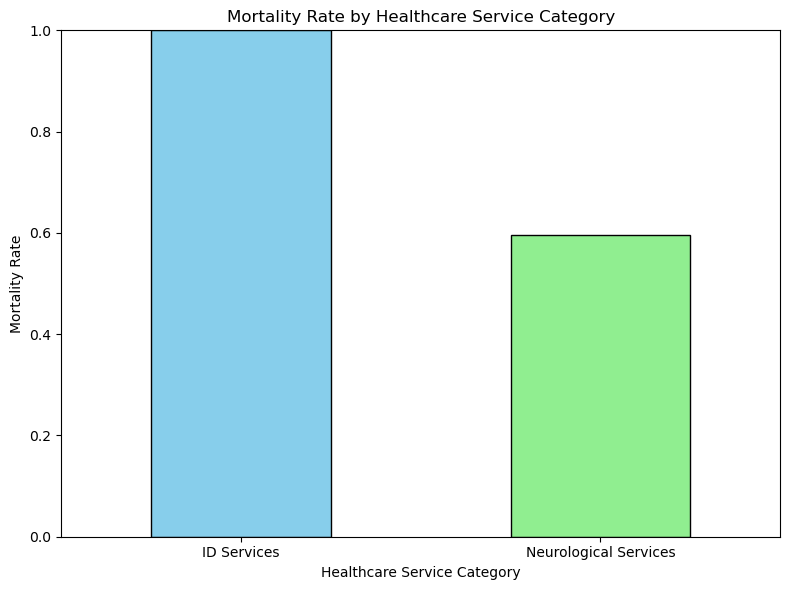

In [53]:
import matplotlib.pyplot as plt

# Calculate the mortality indicator if not already done
df_cleaned['mortality'] = df_cleaned['death_date'].notna().astype(int)

# Group by the new service category and calculate the mortality rate
mortality_rate_by_category = df_cleaned.groupby('service_category')['mortality'].mean().sort_values(ascending=False)

# Plot the mortality rate by service category
plt.figure(figsize=(8, 6))
mortality_rate_by_category.plot(kind='bar', color=['skyblue', 'lightgreen'], edgecolor='black')
plt.title('Mortality Rate by Healthcare Service Category')
plt.xlabel('Healthcare Service Category')
plt.ylabel('Mortality Rate')
plt.xticks(rotation=0)
plt.ylim(0, 1)  # Set y-axis limits to emphasize mortality rate (between 0 and 1)
plt.tight_layout()

# Display the plot
plt.show()


## Feature Selection and Preprocessing

Selecting relevant features, handling missing values, and preparing the dataset for modelling.

Unique values in 'death_epilepsy': [ 0.  1. nan]


<Figure size 1000x600 with 0 Axes>

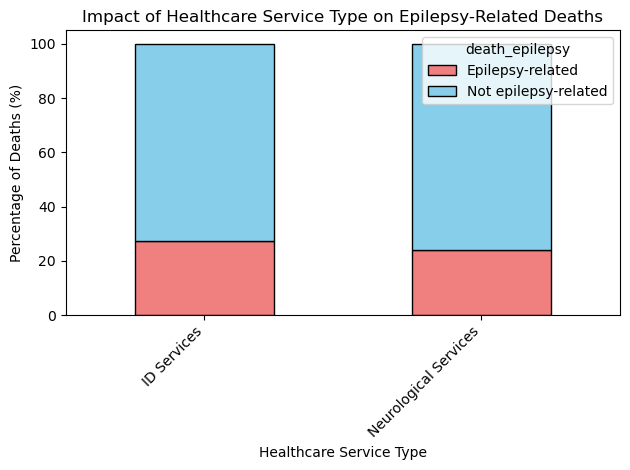

In [55]:
import matplotlib.pyplot as plt

# Define the function to categorize services again
def categorize_service(service):
    id_services = [
        'Oxleas NHS Foundation Trust',
        'Hertfordshire Partnership University NHS Foundation Trust',
        'Central and North West London NHS Foundation Trust',
        'Kent and Medway NHS and Social Care Partnership'
    ]
    
    neurological_services = [
        'Swansea Bay UHB', 'Swansea bay UHB',
        'Royal Free',
        'Gloucestershire',
        'Cornwall'
    ]
    
    if service in id_services:
        return 'ID Services'
    elif service in neurological_services:
        return 'Neurological Services'
    else:
        return 'Unknown'

# Apply the function to create a new column for service category
df_cleaned['service_category'] = df_cleaned['id_service'].apply(categorize_service)

# Check unique values in the 'death_epilepsy' column to understand encoding
print("Unique values in 'death_epilepsy':", df_cleaned['death_epilepsy'].unique())

# Convert 'death_epilepsy' to a binary categorical variable if necessary (assuming 1=Epilepsy-related, 0=Not epilepsy-related)
df_cleaned['death_epilepsy'] = df_cleaned['death_epilepsy'].map({1: 'Epilepsy-related', 0: 'Not epilepsy-related'})

# Filter the data to include only those with valid 'death_epilepsy' data
df_epilepsy_deaths = df_cleaned.dropna(subset=['death_epilepsy'])

# Group by healthcare service type and calculate the percentage of epilepsy-related deaths
epilepsy_deaths_by_service = df_epilepsy_deaths.groupby('service_category')['death_epilepsy'].value_counts(normalize=True).unstack() * 100

# Plot the impact of healthcare service type on epilepsy-related deaths
plt.figure(figsize=(10, 6))
epilepsy_deaths_by_service.plot(kind='bar', stacked=True, color=['lightcoral', 'skyblue'], edgecolor='black')
plt.title('Impact of Healthcare Service Type on Epilepsy-Related Deaths')
plt.xlabel('Healthcare Service Type')
plt.ylabel('Percentage of Deaths (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

C:\Users\Rafal\AppData\Local\Temp\ipykernel_2572\2808128241.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_cleaned, x='polypharmacy', y='mortality', ci=None, palette='viridis')


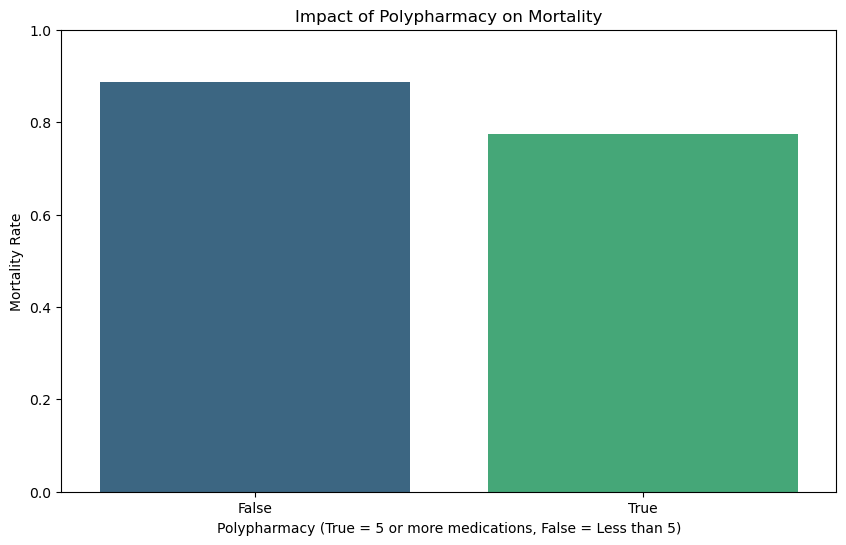

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df_cleaned is already loaded with your dataset

# Convert 'med_total' to numeric if it's not already
df_cleaned['med_total'] = pd.to_numeric(df_cleaned['med_total'], errors='coerce')

# Create a binary mortality indicator based on whether 'death_date' is not null
df_cleaned['mortality'] = df_cleaned['death_date'].notna().astype(int)

# Define the threshold for polypharmacy (e.g., 5 or more medications)
polypharmacy_threshold = 5
df_cleaned['polypharmacy'] = df_cleaned['med_total'] >= polypharmacy_threshold

# Visualize the link between polypharmacy and mortality using a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_cleaned, x='polypharmacy', y='mortality', ci=None, palette='viridis')
plt.title('Impact of Polypharmacy on Mortality')
plt.xlabel('Polypharmacy (True = 5 or more medications, False = Less than 5)')
plt.ylabel('Mortality Rate')
plt.ylim(0, 1)  # Set the y-axis limit to focus on the mortality rate percentage
plt.show()


DataFrame Summary:
<class 'pandas.core.frame.DataFrame'>
Index: 190 entries, 1 to 379
Columns: 106 entries, record_id to seizure_and_sudep_risk_factors_complete
dtypes: float64(86), object(20)
memory usage: 158.8+ KB
None

First 5 rows of the DataFrame:
   record_id  redcap_survey_identifier collaborator_details_timestamp  \
1        7.0                       NaN               20/05/2022 15:08   
3        8.0                       NaN               20/05/2022 15:24   
5        9.0                       NaN               23/05/2022 11:45   
7       10.0                       NaN               23/05/2022 11:55   
9       11.0                       NaN               24/05/2022 10:56   

  first_name  middle_name last_name               email_address  \
1      Lance          NaN   Watkins  lance.watkins@wales.nhs.uk   
3      Lance          NaN   Watkins  lance.watkins@wales.nhs.uk   
5      Lance          NaN   Watkins  lance.watkins@wales.nhs.uk   
7      lance          NaN   Watkins  la

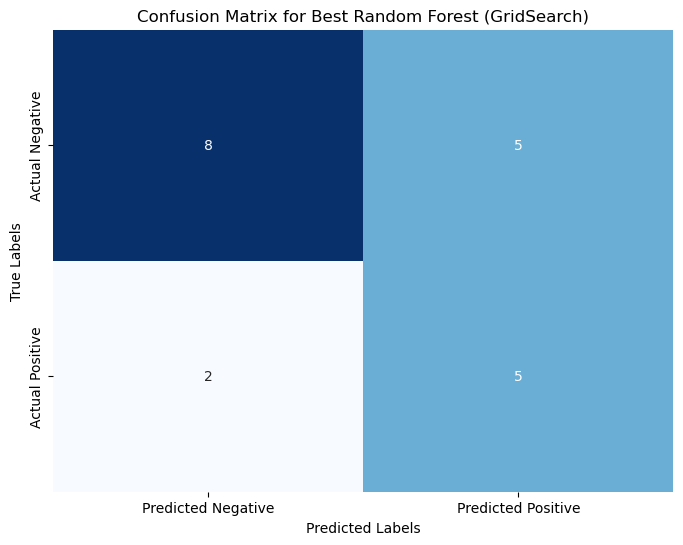

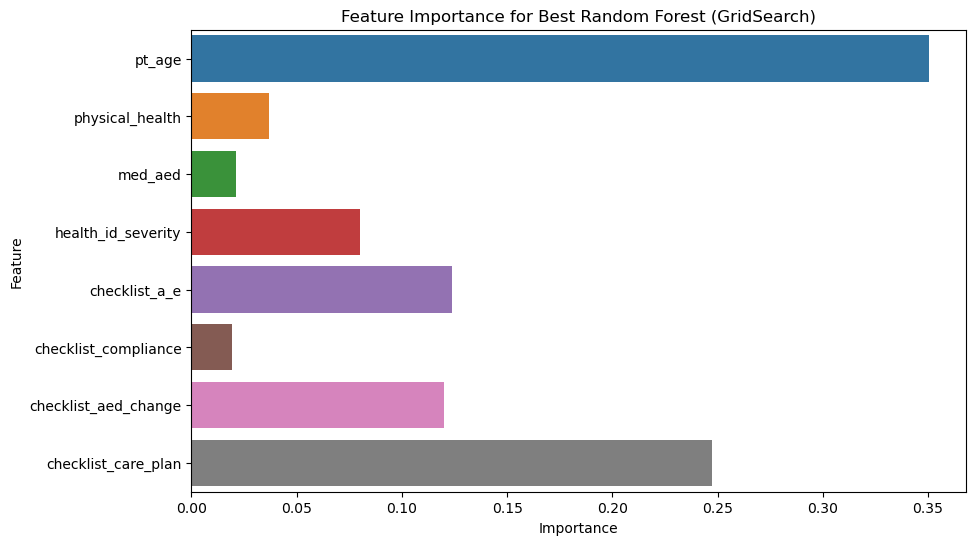


Cross-Validation Accuracy Scores:
[0.875  0.6875 0.75   0.6875 0.8   ]
Mean Cross-Validation Accuracy: 0.76


In [15]:
# Select relevant features
selected_columns = [
    'pt_age', 'physical_health', 'med_aed', 'health_id_severity', 'seizure_frequency',
    'checklist_a_e', 'checklist_compliance', 'checklist_aed_change', 'checklist_care_plan'
]
selected_data = df[selected_columns]

# Drop rows with missing values
selected_data = selected_data.dropna()
print("\nSelected data after dropping missing values:")
print(selected_data.head())

# Feature Selection and Engineering
# Create a binary target variable for mortality based on seizure frequency (proxy for mortality)
median_seizure_frequency = selected_data['seizure_frequency'].median()
selected_data['mortality'] = (selected_data['seizure_frequency'] > median_seizure_frequency).astype(int)

# Split the data into features (X) and target (y)
X = selected_data.drop(columns=['seizure_frequency', 'mortality'])
y = selected_data['mortality']

# Data Preprocessing
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nShape of training and testing sets:")
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Standardise the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Hyperparameter Tuning and Cross-Validation for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set verbose to 0 to suppress detailed print statements
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, refit=True, verbose=0, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train_scaled, y_train)

# Get the best estimator from the grid search
best_rf = grid_search_rf.best_estimator_
print("\nBest hyperparameters from GridSearchCV:")
print(grid_search_rf.best_params_)

# Train the best Random Forest model
best_rf.fit(X_train_scaled, y_train)
y_pred_best_rf = best_rf.predict(X_test_scaled)

# Evaluate the best Random Forest model
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
roc_auc_best_rf = roc_auc_score(y_test, y_pred_best_rf)
conf_matrix_best_rf = confusion_matrix(y_test, y_pred_best_rf)

# Display the evaluation results
evaluation_results_best_rf = {
    "Model": ["Best Random Forest (GridSearch)"],
    "Accuracy": [accuracy_best_rf],
    "ROC-AUC": [roc_auc_best_rf],
    "Confusion Matrix": [conf_matrix_best_rf]
}

evaluation_df_best_rf = pd.DataFrame(evaluation_results_best_rf)
print("\nBest Model Evaluation Results:")
print(evaluation_df_best_rf)

# Displaying confusion matrix in a more readable format
print("\nConfusion Matrix:")
conf_matrix_best_rf_df = pd.DataFrame(conf_matrix_best_rf, columns=["Predicted Negative", "Predicted Positive"], 
                                   index=["Actual Negative", "Actual Positive"])
print(conf_matrix_best_rf_df)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best_rf_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Best Random Forest (GridSearch)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Compute feature importance
feature_importances_rf = best_rf.feature_importances_

# Ploting feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_rf, y=X.columns)
plt.title("Feature Importance for Best Random Forest (GridSearch)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Cross-Validation Score
cv_scores = cross_val_score(best_rf, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("\nCross-Validation Accuracy Scores:")
print(cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())



Best Model Evaluation Results:
                   Model  Accuracy   ROC-AUC  Confusion Matrix
0  Best SVC (GridSearch)       0.6  0.626374  [[7, 6], [2, 5]]

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                   7                   6
Actual Positive                   2                   5


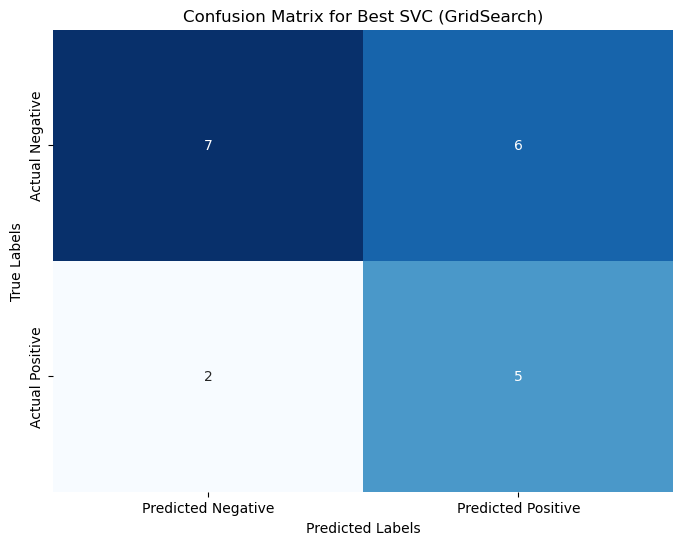

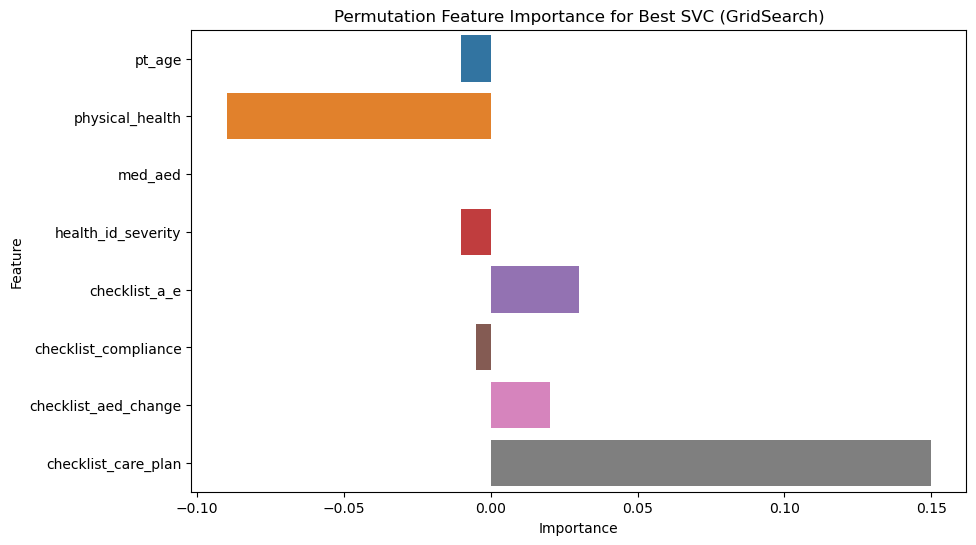

In [6]:
# Feature Selection and Engineering
# Create a binary target variable for mortality based on seizure frequency (proxy for mortality)
median_seizure_frequency = selected_data['seizure_frequency'].median()
selected_data['mortality'] = (selected_data['seizure_frequency'] > median_seizure_frequency).astype(int)

# Split the data into features (X) and target (y)
X = selected_data.drop(columns=['seizure_frequency', 'mortality'])
y = selected_data['mortality']

# Data Preprocessing
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter Tuning and Cross-Validation for SVC
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'linear']
}

# Set verbose to 0 to suppress detailed print statements
grid_search_svc = GridSearchCV(SVC(), param_grid, refit=True, verbose=0, cv=5, scoring='accuracy')
grid_search_svc.fit(X_train_scaled, y_train)

# Get the best estimator from the grid search
best_svc = grid_search_svc.best_estimator_

# Train the best SVC model
best_svc.fit(X_train_scaled, y_train)
y_pred_best_svc = best_svc.predict(X_test_scaled)

# Evaluate the best SVC model
accuracy_best_svc = accuracy_score(y_test, y_pred_best_svc)
roc_auc_best_svc = roc_auc_score(y_test, y_pred_best_svc)
conf_matrix_best_svc = confusion_matrix(y_test, y_pred_best_svc)

# Display the evaluation results
evaluation_results_best_svc = {
    "Model": ["Best SVC (GridSearch)"],
    "Accuracy": [accuracy_best_svc],
    "ROC-AUC": [roc_auc_best_svc],
    "Confusion Matrix": [conf_matrix_best_svc]
}

evaluation_df_best_svc = pd.DataFrame(evaluation_results_best_svc)
print("\nBest Model Evaluation Results:")
print(evaluation_df_best_svc)

# Optional: Display confusion matrix in a more readable format
print("\nConfusion Matrix:")
conf_matrix_best_df = pd.DataFrame(conf_matrix_best_svc, columns=["Predicted Negative", "Predicted Positive"], 
                                   index=["Actual Negative", "Actual Positive"])
print(conf_matrix_best_df)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Best SVC (GridSearch)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Compute permutation feature importance
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(best_svc, X_test_scaled, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Extract the feature importances
feature_names = X.columns
importances = perm_importance.importances_mean

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("Permutation Feature Importance for Best SVC (GridSearch)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

## SHAP Interpretation

Using SHAP values to explain model predictions and understand feature impact.

Logistic Regression Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.93      0.87        30
         1.0       0.50      0.25      0.33         8

    accuracy                           0.79        38
   macro avg       0.66      0.59      0.60        38
weighted avg       0.76      0.79      0.76        38

Logistic Regression ROC-AUC Score: 0.7208333333333333
Logistic Regression Feature Importance:
 med_aed                 0.480505
checklist_care_plan     0.389436
checklist_compliance   -0.245073
checklist_aed_change   -0.245294
checklist_a_e          -0.304313
physical_health        -0.371502
health_id_severity     -0.436386
pt_age                 -0.557779
dtype: float64
Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.93      0.86        30
         1.0       0.33      0.12      0.18         8

    accuracy                           0.76        38

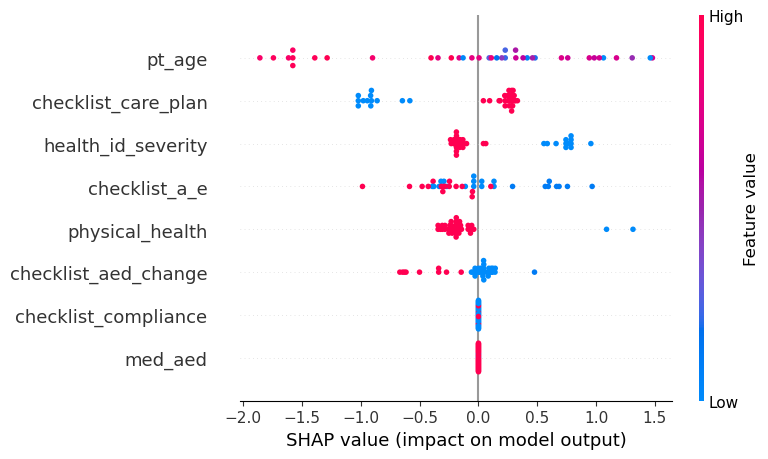

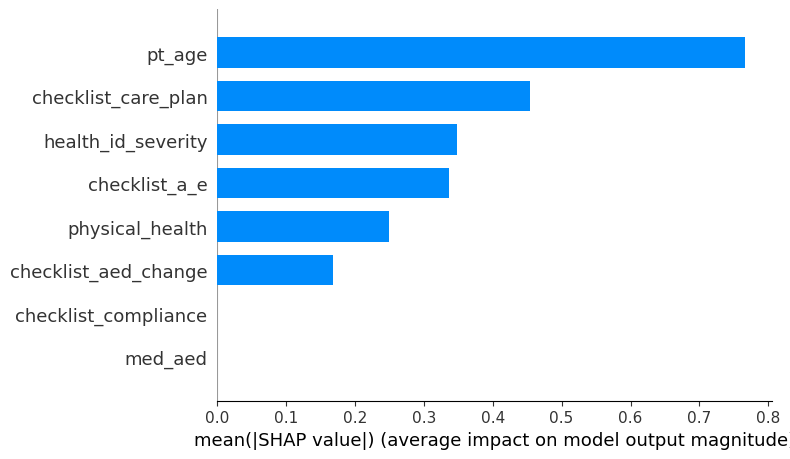

Cross-Validation ROC-AUC Scores: [0.80414747 0.72119816 0.61666667 0.61666667 0.80416667]
Average Cross-Validation ROC-AUC Score: 0.7125691244239631


In [2]:
# Selecting relevant columns based on previous insights
selected_columns = [
    'pt_age', 'physical_health', 'med_aed', 'health_id_severity',
    'checklist_a_e', 'checklist_compliance', 'checklist_aed_change', 'checklist_care_plan',
    'death_epilepsy'
]

# Filter dataset to include only the selected columns and make a copy to avoid SettingWithCopyWarning
data_filtered = df[selected_columns].copy()

# Handle missing values
num_cols = ['pt_age', 'physical_health', 'med_aed', 'health_id_severity', 
            'checklist_a_e', 'checklist_compliance', 'checklist_aed_change', 'checklist_care_plan']
cat_cols = ['death_epilepsy']

# Impute missing numerical values with the median
num_imputer = SimpleImputer(strategy='median')
data_filtered.loc[:, num_cols] = num_imputer.fit_transform(data_filtered[num_cols])

# Impute missing categorical values with the mode
cat_imputer = SimpleImputer(strategy='most_frequent')
data_filtered.loc[:, cat_cols] = cat_imputer.fit_transform(data_filtered[cat_cols])

# Subset the data to include only the selected features
X = data_filtered[selected_columns[:-1]]  # All selected columns except 'death_epilepsy'
y = data_filtered['death_epilepsy']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Baseline Model with Logistic Regression
# Create a logistic regression model pipeline with scaling
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('logreg', LogisticRegression(solver='liblinear', random_state=42))
])

# Fit the logistic regression model
logreg_pipeline.fit(X_train, y_train)

# Predict and evaluate the logistic regression model
y_pred_logreg = logreg_pipeline.predict(X_test)
y_pred_proba_logreg = logreg_pipeline.predict_proba(X_test)[:, 1]

# Classification report and ROC-AUC score for logistic regression
report_logreg = classification_report(y_test, y_pred_logreg, zero_division=1)
roc_auc_logreg = roc_auc_score(y_test, y_pred_proba_logreg)

print("Logistic Regression Classification Report:\n", report_logreg)
print("Logistic Regression ROC-AUC Score:", roc_auc_logreg)

# Print coefficients to understand feature impact
coefficients = logreg_pipeline.named_steps['logreg'].coef_[0]
feature_importance = pd.Series(coefficients, index=X.columns).sort_values(ascending=False)
print("Logistic Regression Feature Importance:\n", feature_importance)

# Step 4: Random Forest Model
# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate the Random Forest model
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Classification report and ROC-AUC score for Random Forest
report_rf = classification_report(y_test, y_pred_rf, zero_division=1)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print("Random Forest Classification Report:\n", report_rf)
print("Random Forest ROC-AUC Score:", roc_auc_rf)

# Feature importance from Random Forest
rf_feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Random Forest Feature Importance:\n", rf_feature_importance)

# Step 5: XGBoost Model
# Initialize and train XGBoost model
xgb_model = XGBClassifier(
    eval_metric='logloss',
    max_depth=3,
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Predict and evaluate the XGBoost model
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Classification report and ROC-AUC score for XGBoost
report_xgb = classification_report(y_test, y_pred_xgb, zero_division=1)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

print("XGBoost Classification Report:\n", report_xgb)
print("XGBoost ROC-AUC Score:", roc_auc_xgb)

# Feature importance from XGBoost
xgb_feature_importance = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("XGBoost Feature Importance:\n", xgb_feature_importance)

# Step 6: Model Interpretation with SHAP
# Calculate SHAP values for XGBoost
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

# Summary plot to show feature importance
shap.summary_plot(shap_values, X_test)

# Bar plot to show mean absolute SHAP value for each feature
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Step 7: Cross-Validation
# Use cross-validation for XGBoost
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_model, X, y, cv=cv, scoring='roc_auc')

print("Cross-Validation ROC-AUC Scores:", cv_scores)
print("Average Cross-Validation ROC-AUC Score:", cv_scores.mean())


## Data Loading and Initial Inspection

Loading the dataset and reviewing basic structure and data integrity.

In [1]:
# Load the dataset
df = pd.read_csv('EpilepsyInIntellectu_DATA_2022-08-28_1524 final_ROHIT.csv', skip_blank_lines=True)
df = df.dropna(how='all')

# Selecting relevant columns based on previous insights
selected_columns = [
    'pt_age', 'physical_health', 'med_aed', 'health_id_severity',
    'checklist_a_e', 'checklist_compliance', 'checklist_aed_change', 'checklist_care_plan',
    'death_epilepsy'
]

# Filter dataset to include only the selected columns and make a copy to avoid SettingWithCopyWarning
data_filtered = df[selected_columns].copy()

# Handle missing values
from sklearn.impute import SimpleImputer

num_cols = ['pt_age', 'physical_health', 'med_aed', 'health_id_severity', 
            'checklist_a_e', 'checklist_compliance', 'checklist_aed_change', 'checklist_care_plan']
cat_cols = ['death_epilepsy']

# Impute missing numerical values with the median
num_imputer = SimpleImputer(strategy='median')
data_filtered.loc[:, num_cols] = num_imputer.fit_transform(data_filtered[num_cols])

# Impute missing categorical values with the mode
cat_imputer = SimpleImputer(strategy='most_frequent')
data_filtered.loc[:, cat_cols] = cat_imputer.fit_transform(data_filtered[cat_cols])

# Subset the data to include only the selected features
X = data_filtered[selected_columns[:-1]]  # All selected columns except 'death_epilepsy'
y = data_filtered['death_epilepsy']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Calculate the scale_pos_weight parameter
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Initialize and train the XGBoost model with adjusted class weights
xgb_model = XGBClassifier(
    eval_metric='logloss',
    max_depth=3,
    n_estimators=100,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Predict and evaluate the XGBoost model
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Classification report and ROC-AUC score for XGBoost
report_xgb = classification_report(y_test, y_pred_xgb, zero_division=1)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

print("XGBoost Classification Report with Class Weight Adjustment:\n", report_xgb)
print("XGBoost ROC-AUC Score with Class Weight Adjustment:", roc_auc_xgb)

# Feature importance from XGBoost
xgb_feature_importance = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("XGBoost Feature Importance:\n", xgb_feature_importance)


XGBoost Classification Report with Class Weight Adjustment:
               precision    recall  f1-score   support

         0.0       0.87      0.90      0.89        30
         1.0       0.57      0.50      0.53         8

    accuracy                           0.82        38
   macro avg       0.72      0.70      0.71        38
weighted avg       0.81      0.82      0.81        38

XGBoost ROC-AUC Score with Class Weight Adjustment: 0.7458333333333333
XGBoost Feature Importance:
 health_id_severity      0.205677
physical_health         0.198695
checklist_care_plan     0.145295
pt_age                  0.133555
checklist_a_e           0.120283
checklist_aed_change    0.105320
med_aed                 0.068773
checklist_compliance    0.022402
dtype: float32


DataFrame Summary:
<class 'pandas.core.frame.DataFrame'>
Index: 190 entries, 1 to 379
Columns: 106 entries, record_id to seizure_and_sudep_risk_factors_complete
dtypes: float64(86), object(20)
memory usage: 158.8+ KB
None

First 5 rows of the DataFrame:
   record_id  redcap_survey_identifier collaborator_details_timestamp  \
1        7.0                       NaN               20/05/2022 15:08   
3        8.0                       NaN               20/05/2022 15:24   
5        9.0                       NaN               23/05/2022 11:45   
7       10.0                       NaN               23/05/2022 11:55   
9       11.0                       NaN               24/05/2022 10:56   

  first_name  middle_name last_name               email_address  \
1      Lance          NaN   Watkins  lance.watkins@wales.nhs.uk   
3      Lance          NaN   Watkins  lance.watkins@wales.nhs.uk   
5      Lance          NaN   Watkins  lance.watkins@wales.nhs.uk   
7      lance          NaN   Watkins  la

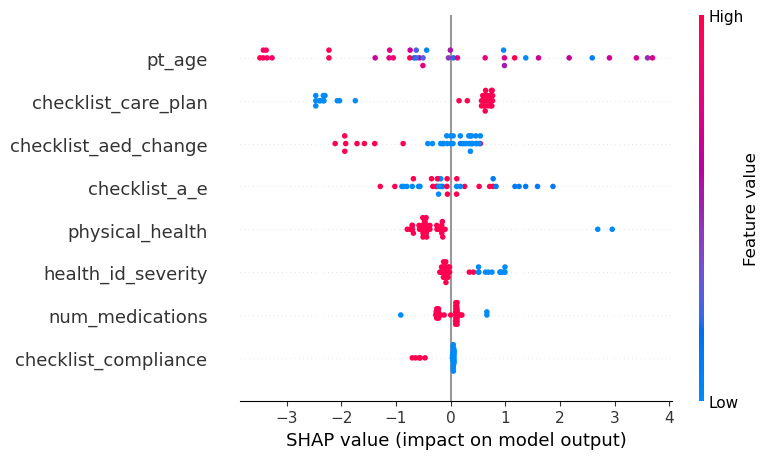

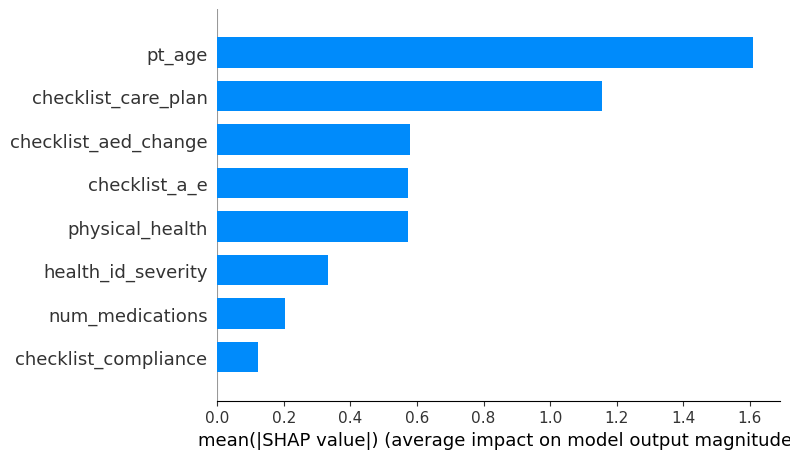

<Figure size 640x480 with 0 Axes>

In [3]:
df = pd.read_csv('EpilepsyInIntellectu_DATA_2022-08-28_1524 final_ROHIT.csv', skip_blank_lines=True)
df = df.dropna(how='all')

# Check if the data has been loaded correctly
print("DataFrame Summary:")
print(df.info())
print("\nFirst 5 rows of the DataFrame:")
print(df.head())

# Engineer features related to polypharmacy (e.g., count the number of medications)
# Here, we assume 'med_aed' column represents a binary feature for AED medication use, and we'll create a polypharmacy feature
df['num_medications'] = df[['med_aed']].sum(axis=1)  # Adjust this based on available columns for medications

# Selecting relevant columns based on previous insights and new polypharmacy feature
selected_columns = [
    'pt_age', 'physical_health', 'health_id_severity', 'num_medications',
    'checklist_a_e', 'checklist_compliance', 'checklist_aed_change', 'checklist_care_plan',
    'death_epilepsy'
]

# Filter dataset to include only the selected columns and make a copy to avoid SettingWithCopyWarning
data_filtered = df[selected_columns].copy()

# Handle missing values
from sklearn.impute import SimpleImputer

num_cols = ['pt_age', 'physical_health', 'health_id_severity', 'num_medications',
            'checklist_a_e', 'checklist_compliance', 'checklist_aed_change', 'checklist_care_plan']
cat_cols = ['death_epilepsy']

# Impute missing numerical values with the median
num_imputer = SimpleImputer(strategy='median')
data_filtered.loc[:, num_cols] = num_imputer.fit_transform(data_filtered[num_cols])

# Impute missing categorical values with the mode
cat_imputer = SimpleImputer(strategy='most_frequent')
data_filtered.loc[:, cat_cols] = cat_imputer.fit_transform(data_filtered[cat_cols])

# Subset the data to include only the selected features
X = data_filtered[selected_columns[:-1]]  # All selected columns except 'death_epilepsy'
y = data_filtered['death_epilepsy']

# Standardize features for better model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Model Training

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the XGBoost model with parameter tuning
xgb_model = XGBClassifier(
    eval_metric='logloss',
    max_depth=3,
    n_estimators=100,
    learning_rate=0.1,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  # Handle class imbalance
    random_state=42
)

# Hyperparameter tuning (optional)
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='roc_auc', verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_xgb_model = grid_search.best_estimator_

# Train the best XGBoost model
best_xgb_model.fit(X_train, y_train)

# Step 3: Evaluation and Interpretation

# Predict and evaluate the XGBoost model
y_pred_xgb = best_xgb_model.predict(X_test)
y_pred_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

# Classification report and ROC-AUC score for XGBoost
report_xgb = classification_report(y_test, y_pred_xgb, zero_division=1)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

print("XGBoost Classification Report:\n", report_xgb)
print("XGBoost ROC-AUC Score:", roc_auc_xgb)

# Feature importance from XGBoost
xgb_feature_importance = pd.Series(best_xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("XGBoost Feature Importance:\n", xgb_feature_importance)

# SHAP Values for model interpretation
explainer = shap.Explainer(best_xgb_model, X_train)
shap_values = explainer(X_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# Step 4: Insights and Recommendations

# Analyze SHAP values to identify the impact of polypharmacy and other features
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar")

# Save SHAP plot as needed
plt.savefig("shap_summary_plot.png")

# Further analysis and model interpretation


In [30]:
df = pd.read_csv('EpilepsyInIntellectu_DATA_2022-08-28_1524 final_ROHIT.csv', skip_blank_lines=True)
df = df.dropna(how='all')

# Check if the data has been loaded correctly
print("DataFrame Summary:")
print(df.info())
print("\nFirst 5 rows of the DataFrame:")
print(df.head())

DataFrame Summary:
<class 'pandas.core.frame.DataFrame'>
Index: 190 entries, 1 to 379
Columns: 106 entries, record_id to seizure_and_sudep_risk_factors_complete
dtypes: float64(86), object(20)
memory usage: 158.8+ KB
None

First 5 rows of the DataFrame:
   record_id  redcap_survey_identifier collaborator_details_timestamp  \
1        7.0                       NaN               20/05/2022 15:08   
3        8.0                       NaN               20/05/2022 15:24   
5        9.0                       NaN               23/05/2022 11:45   
7       10.0                       NaN               23/05/2022 11:55   
9       11.0                       NaN               24/05/2022 10:56   

  first_name  middle_name last_name               email_address  \
1      Lance          NaN   Watkins  lance.watkins@wales.nhs.uk   
3      Lance          NaN   Watkins  lance.watkins@wales.nhs.uk   
5      Lance          NaN   Watkins  lance.watkins@wales.nhs.uk   
7      lance          NaN   Watkins  la

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 190 entries, 1 to 379
Columns: 106 entries, record_id to seizure_and_sudep_risk_factors_complete
dtypes: float64(86), object(20)
memory usage: 158.8+ KB


In [34]:
df = pd.read_csv('EpilepsyInIntellectu_DATA_2022-08-28_1524 final_ROHIT.csv', skip_blank_lines=True)
df

,record_id,redcap_survey_identifier,collaborator_details_timestamp,first_name,middle_name,last_name,email_address,id_service,id_service_address,collaborator_details_complete,...,checklist_surv_type,checklist_sleep_pos,checklist_a_e,checklist_compliance,checklist_aed_change,checklist_alcohol,checklist_drugs,checklist_care_plan,checklist_discussion,seizure_and_sudep_risk_factors_complete
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7.0,NaN,20/05/2022 15:08,Lance,NaN,Watkins,lance.watkins@wales.nhs.uk,Swansea Bay UHB,Port Talbot,2.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8.0,NaN,20/05/2022 15:24,Lance,NaN,Watkins,lance.watkins@wales.nhs.uk,Swansea Bay UHB,Port Talbot,2.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,9.0,NaN,23/05/2022 11:45,Lance,NaN,Watkins,lance.watkins@wales.nhs.uk,Swansea Bay UHB,Port Talbot,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,10.0,NaN,23/05/2022 11:55,lance,NaN,Watkins,lance.watkins@wales.nhs.uk,Swansea Bay UHB,Port Talbot,2.0,...,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,9.0,2.0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,11.0,NaN,24/05/2022 10:56,Lance,NaN,Watkins,lance.watkins@wales.nhs.uk,Swansea Bay UHB,Port Talbot,2.0,...,Video monitor,2.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0


In [36]:
# Drop rows where all column values are missing
df_cleaned = df.dropna(how='all')

# Display the cleaned DataFrame
df_cleaned

,record_id,redcap_survey_identifier,collaborator_details_timestamp,first_name,middle_name,last_name,email_address,id_service,id_service_address,collaborator_details_complete,...,checklist_surv_type,checklist_sleep_pos,checklist_a_e,checklist_compliance,checklist_aed_change,checklist_alcohol,checklist_drugs,checklist_care_plan,checklist_discussion,seizure_and_sudep_risk_factors_complete
1,7.0,NaN,20/05/2022 15:08,Lance,NaN,Watkins,lance.watkins@wales.nhs.uk,Swansea Bay UHB,Port Talbot,2.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
3,8.0,NaN,20/05/2022 15:24,Lance,NaN,Watkins,lance.watkins@wales.nhs.uk,Swansea Bay UHB,Port Talbot,2.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
5,9.0,NaN,23/05/2022 11:45,Lance,NaN,Watkins,lance.watkins@wales.nhs.uk,Swansea Bay UHB,Port Talbot,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,10.0,NaN,23/05/2022 11:55,lance,NaN,Watkins,lance.watkins@wales.nhs.uk,Swansea Bay UHB,Port Talbot,2.0,...,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,9.0,2.0
9,11.0,NaN,24/05/2022 10:56,Lance,NaN,Watkins,lance.watkins@wales.nhs.uk,Swansea Bay UHB,Port Talbot,2.0,...,Video monitor,2.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0
11,12.0,NaN,24/05/2022 11:36,lance,NaN,Watkins,lance.watkins@wales.nhs.uk,Swansea Bay UHB,Port Talbot,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,13.0,NaN,24/05/2022 11:43,Lance,NaN,Watkins,lance.watkins@wales.nhs.uk,Swansea Bay UHB,Port Talbot,2.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
15,14.0,NaN,24/05/2022 13:28,Lance,NaN,Watkins,lance.watkins@wales.nhs.uk,Swansea Bay UHB,Port Talbot,2.0,...,video monitor,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
17,15.0,NaN,24/05/2022 13:50,Lance,NaN,Watkins,lance.watkins@wales.nhs.uk,Swansea Bay UHB,Port Talbot,2.0,...,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,9.0,2.0
19,16.0,NaN,24/05/2022 14:21,Lance,NaN,Watkins,lance.watkins@wales.nhs.uk,Swansea Bay UHB,Port Talbot,2.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0


In [37]:
unique_id_service_values = df_cleaned['id_service'].unique()
unique_id_service_values

array(['Swansea Bay UHB', 'Swansea bay UHB', 'Royal Free',
       'Central and North West London NHS Foundation Trust',
       'Kent and Medway NHS and Social Care Partnership',
       'Gloucestershire', 'Cornwall', 'Oxleas NHS Foundation Trust',
       'Hertfordshire Partnership University NHS Foundation Trust'],
      dtype=object)

In [38]:
# Calculate the mortality indicator
df_cleaned['mortality'] = df_cleaned['death_date'].notna().astype(int)

# Ensure the DataFrame has no NaN values in the columns used for plotting
df_cleaned = df_cleaned.dropna(subset=['mortality', 'seizure_frequency'])

# Group by the new service category and calculate the mortality rate
mortality_rate_by_category = df_cleaned.groupby('service_category')['mortality'].mean().sort_values(ascending=False)

# Plot the mortality rate by service category
plt.figure(figsize=(8, 6))
mortality_rate_by_category.plot(kind='bar', color=['skyblue', 'lightgreen'], edgecolor='black')
plt.title('Mortality Rate by Healthcare Service Category')
plt.xlabel('Healthcare Service Category')
plt.ylabel('Mortality Rate')
plt.xticks(rotation=0)
plt.ylim(0, 1)  # Set y-axis limits to emphasize mortality rate (between 0 and 1)
plt.tight_layout()

# Display the plot
plt.show()


C:\Users\Rafal\AppData\Local\Temp\ipykernel_23368\3068914430.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['mortality'] = df_cleaned['death_date'].notna().astype(int)


KeyError: 'service_category'

Unique values in 'pt_gender': [1. 2.]


C:\Users\Rafal\AppData\Local\Temp\ipykernel_23368\3213402504.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['pt_gender'] = df_cleaned['pt_gender'].map({1: 'Male', 2: 'Female'})


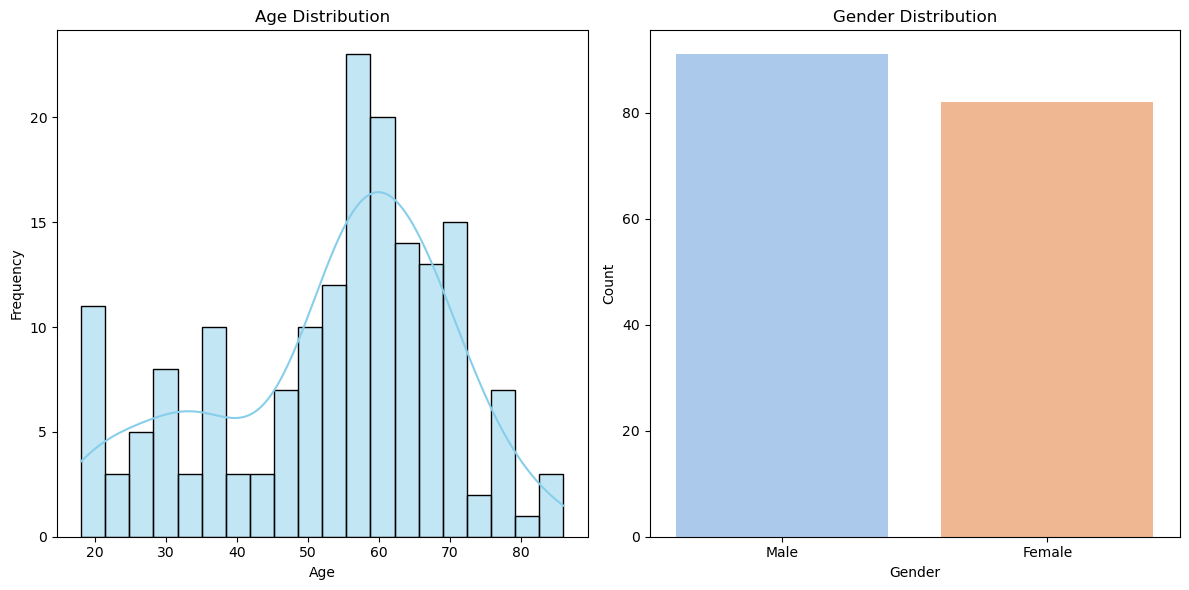

C:\Users\Rafal\AppData\Local\Temp\ipykernel_23368\3213402504.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['age_group'] = pd.cut(df_cleaned['pt_age'], bins=[0, 18, 35, 50, 65, 100], labels=['0-18', '19-35', '36-50', '51-65', '66+'])


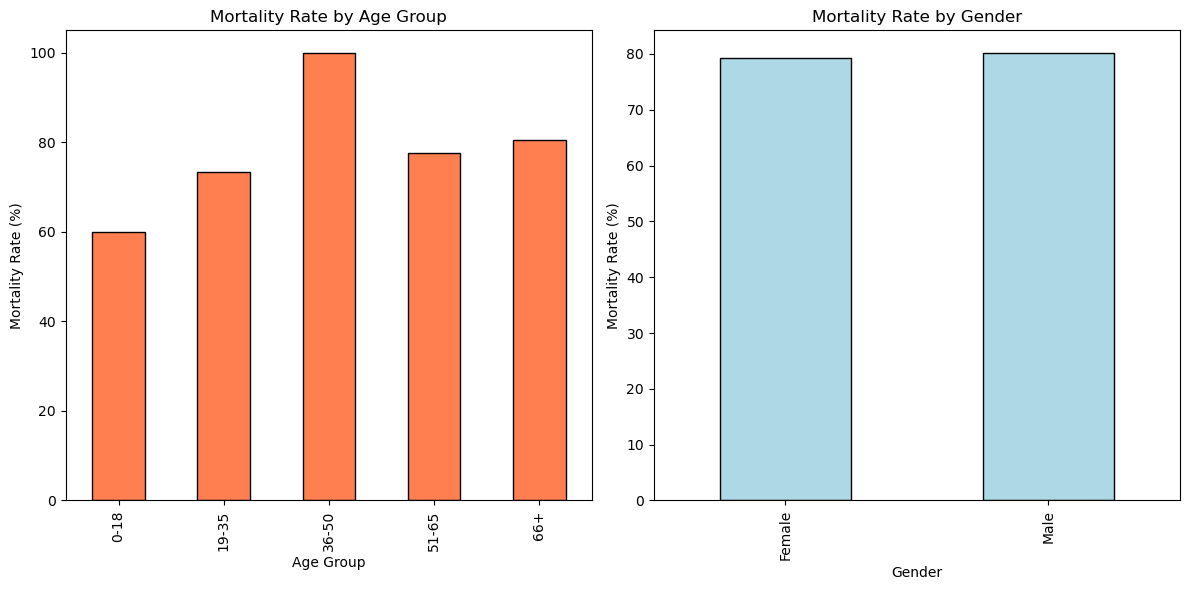

In [39]:
# Check for unique values in 'pt_gender' to understand its encoding
print("Unique values in 'pt_gender':", df_cleaned['pt_gender'].unique())

# Convert 'pt_gender' to a categorical variable if necessary (assuming 1=Male, 2=Female)
df_cleaned['pt_gender'] = df_cleaned['pt_gender'].map({1: 'Male', 2: 'Female'})

# Age and Gender Distribution
plt.figure(figsize=(12, 6))

# Age distribution
plt.subplot(1, 2, 1)
sns.histplot(df_cleaned['pt_age'], bins=20, kde=True, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Gender distribution
plt.subplot(1, 2, 2)
sns.countplot(x='pt_gender', data=df_cleaned, palette='pastel')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Impact of Demographics on Mortality
plt.figure(figsize=(12, 6))

# Mortality rate by age group
df_cleaned['age_group'] = pd.cut(df_cleaned['pt_age'], bins=[0, 18, 35, 50, 65, 100], labels=['0-18', '19-35', '36-50', '51-65', '66+'])
mortality_by_age = df_cleaned.groupby('age_group')['mortality'].mean() * 100

plt.subplot(1, 2, 1)
mortality_by_age.plot(kind='bar', color='coral', edgecolor='black')
plt.title('Mortality Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Mortality Rate (%)')

# Mortality rate by gender
mortality_by_gender = df_cleaned.groupby('pt_gender')['mortality'].mean() * 100

plt.subplot(1, 2, 2)
mortality_by_gender.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Mortality Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Mortality Rate (%)')

plt.tight_layout()
plt.show()


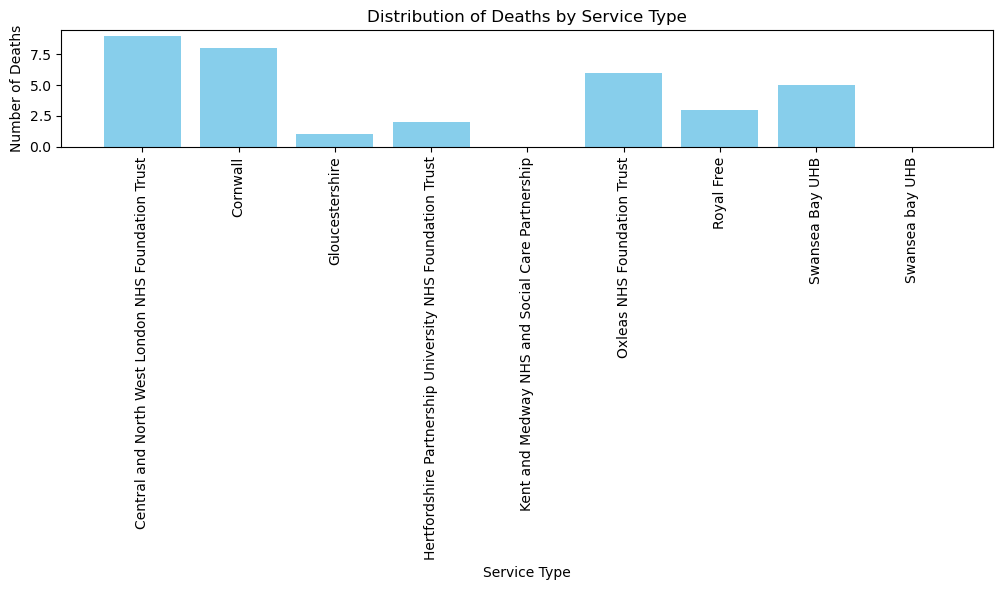

In [41]:
# Calculate the distribution of deaths by service type
death_distribution_by_service = df_cleaned.groupby('id_service')['death_epilepsy'].sum().reset_index()

# Rename columns for clarity
death_distribution_by_service.columns = ['Service Type', 'Number of Deaths']

# Plot the distribution of deaths by service type
plt.figure(figsize=(10, 6))
plt.bar(death_distribution_by_service['Service Type'], death_distribution_by_service['Number of Deaths'], color='skyblue')
plt.xticks(rotation=90)
plt.title('Distribution of Deaths by Service Type')
plt.xlabel('Service Type')
plt.ylabel('Number of Deaths')
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\Rafal\AppData\Local\Temp\ipykernel_23368\2291527381.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['seizure_frequency'] = pd.to_numeric(df_cleaned['seizure_frequency'], errors='coerce')
C:\Users\Rafal\AppData\Local\Temp\ipykernel_23368\2291527381.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_cleaned, x='mortality', y='seizure_frequency', ci=None, palette='viridis')


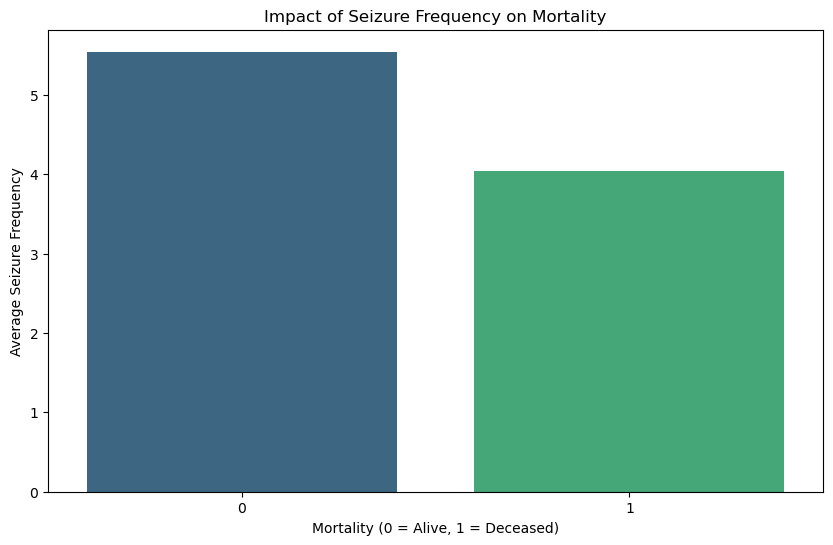

In [42]:
# Ensure 'seizure_frequency' is numeric for plotting
df_cleaned['seizure_frequency'] = pd.to_numeric(df_cleaned['seizure_frequency'], errors='coerce')

# Plot the relationship between seizure frequency and mortality using a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_cleaned, x='mortality', y='seizure_frequency', ci=None, palette='viridis')
plt.title('Impact of Seizure Frequency on Mortality')
plt.xlabel('Mortality (0 = Alive, 1 = Deceased)')
plt.ylabel('Average Seizure Frequency')
plt.show()


C:\Users\Rafal\AppData\Local\Temp\ipykernel_23368\683606937.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['pt_age'] = pd.to_numeric(df_cleaned['pt_age'], errors='coerce')
C:\Users\Rafal\AppData\Local\Temp\ipykernel_23368\683606937.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['seizure_frequency'] = pd.to_numeric(df_cleaned['seizure_frequency'], errors='coerce')
C:\Users\Rafal\AppData\Local\Temp\ipykernel_23368\683606937.py:4: SettingWithCopyWarning: 
A value is trying to be

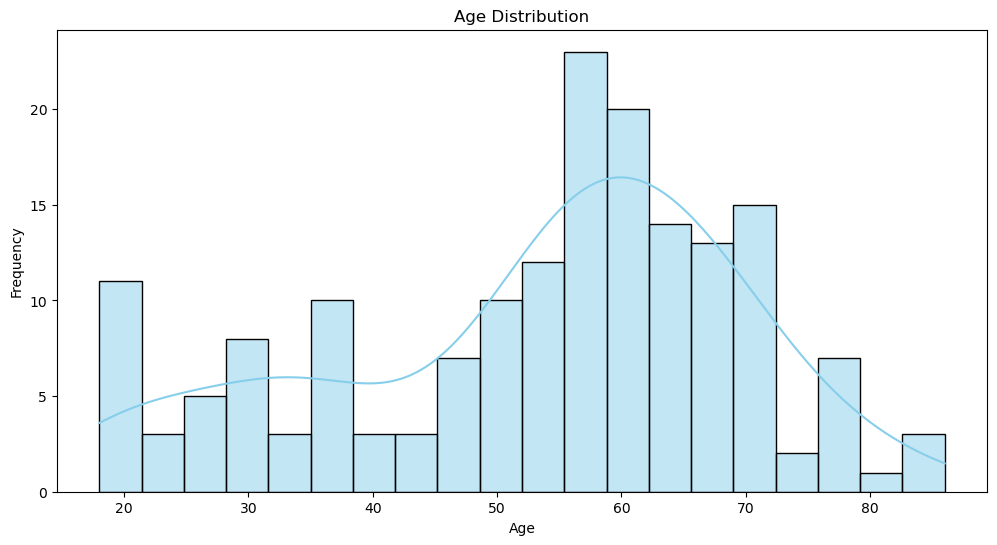

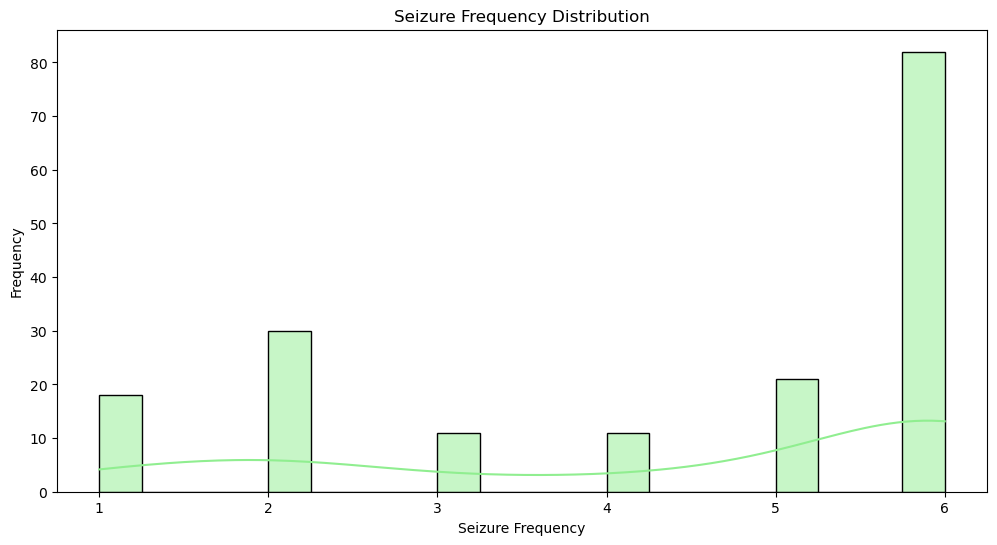

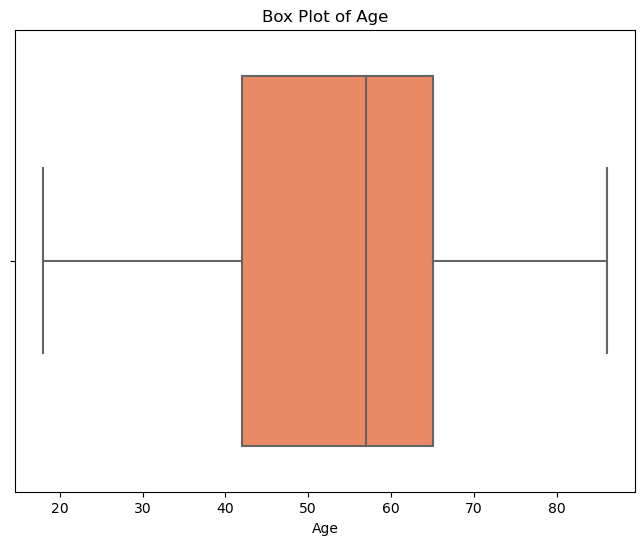

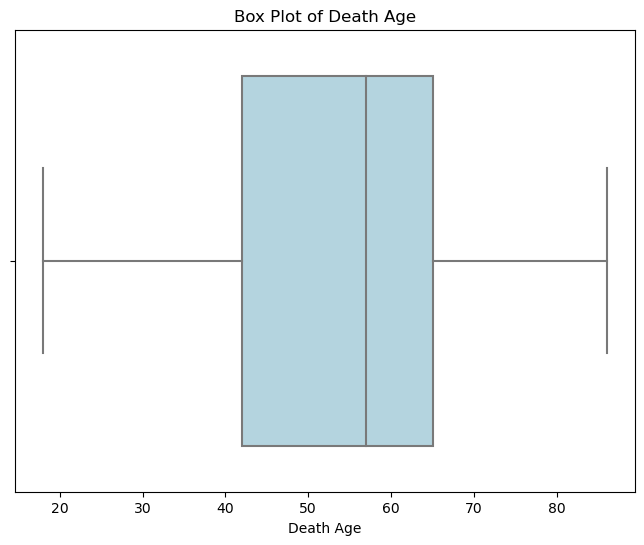

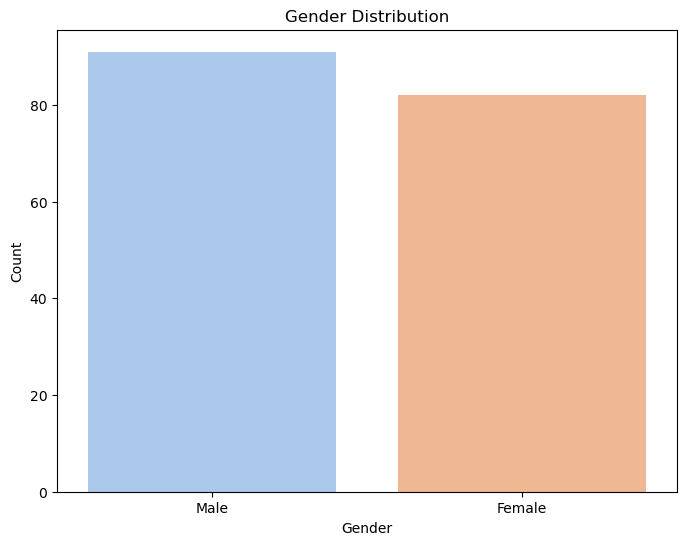

ValueError: Could not interpret input 'service_category'

<Figure size 800x600 with 0 Axes>

In [43]:
# Ensure necessary columns are in numeric format where applicable
df_cleaned['pt_age'] = pd.to_numeric(df_cleaned['pt_age'], errors='coerce')
df_cleaned['seizure_frequency'] = pd.to_numeric(df_cleaned['seizure_frequency'], errors='coerce')
df_cleaned['death_age'] = pd.to_numeric(df_cleaned['death_age'], errors='coerce')

# 1. Histograms and Density Plots for Continuous Variables

# Histogram and density plot for age
plt.figure(figsize=(12, 6))
sns.histplot(df_cleaned['pt_age'], bins=20, kde=True, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Histogram and density plot for seizure frequency
plt.figure(figsize=(12, 6))
sns.histplot(df_cleaned['seizure_frequency'], bins=20, kde=True, color='lightgreen')
plt.title('Seizure Frequency Distribution')
plt.xlabel('Seizure Frequency')
plt.ylabel('Frequency')
plt.show()

# 2. Box Plots for Spread and Outliers

# Box plot for age
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_cleaned['pt_age'], color='coral')
plt.title('Box Plot of Age')
plt.xlabel('Age')
plt.show()

# Box plot for death age
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_cleaned['death_age'], color='lightblue')
plt.title('Box Plot of Death Age')
plt.xlabel('Death Age')
plt.show()

# 3. Bar Plots for Categorical Variables

# Bar plot for gender
plt.figure(figsize=(8, 6))
sns.countplot(x='pt_gender', data=df_cleaned, palette='pastel')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Bar plot for service category
plt.figure(figsize=(8, 6))
sns.countplot(x='service_category', data=df_cleaned, palette='pastel')
plt.title('Service Category Distribution')
plt.xlabel('Service Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Bar plot for seizure type
plt.figure(figsize=(10, 6))
sns.countplot(x='seizure_type', data=df_cleaned, palette='pastel')
plt.title('Seizure Type Distribution')
plt.xlabel('Seizure Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# 4. Heatmap for Correlation

# Calculate the correlation matrix for numerical columns
correlation_matrix = df_cleaned[['pt_age', 'seizure_frequency', 'death_age', 'med_total']].corr()

# Heatmap for visualizing correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Selected Features')
plt.show()


In [38]:
# Categorize healthcare services into 'Specialized' and 'General'
# Define your categories based on your dataset. Here's an example setup:

specialized_services = ['Neurology Department', 'Epilepsy Specialist Clinic', 'Neurophysiology Unit']
general_services = ['General Practitioner', 'Community Health Service', 'General Hospital']

# Add a new column to the dataframe to specify if a service is specialized or general
df_cleaned['service_category'] = df_cleaned['id_service'].apply(
    lambda x: 'Specialized' if x in specialized_services else 'General'
)


In [79]:
# Create a function to categorize the services
def categorize_service(service):
    id_services = [
        'Oxleas NHS Foundation Trust',
        'Hertfordshire Partnership University NHS Foundation Trust',
        'Central and North West London NHS Foundation Trust',
        'Kent and Medway NHS and Social Care Partnership'
    ]
    
    neurological_services = [
        'Swansea Bay UHB', 'Swansea bay UHB',
        'Royal Free',
        'Gloucestershire',
        'Cornwall'
    ]
    
    if service in id_services:
        return 'ID Services'
    elif service in neurological_services:
        return 'Neurological Services'
    else:
        return 'Unknown'

# Apply the function to create a new column for service category
df_cleaned['service_category'] = df_cleaned['id_service'].apply(categorize_service)

# Display the unique values in the new 'service_category' column
df_cleaned['service_category'].unique()


array(['Neurological Services', 'ID Services'], dtype=object)

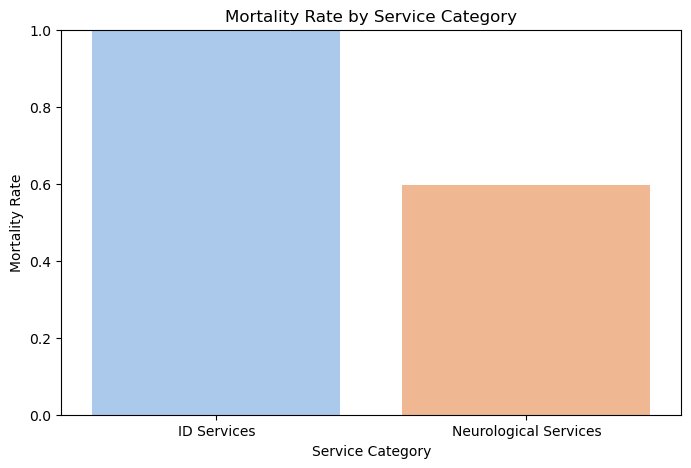

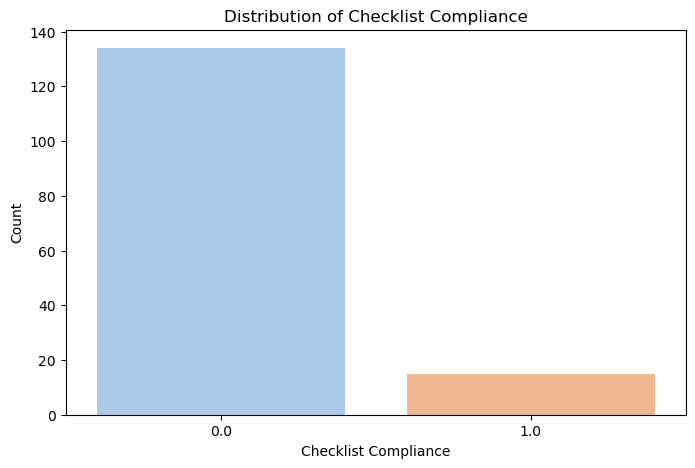

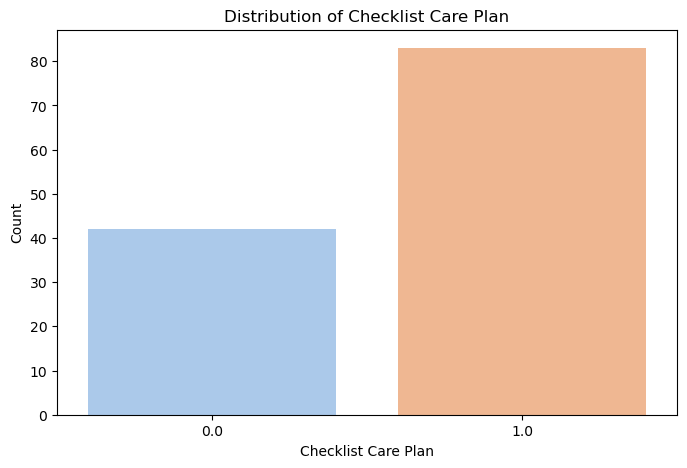

In [63]:
df_cleaned['mortality'] = df_cleaned['death_date'].notna().astype(int)

# Group by service category and calculate the mortality rate
mortality_by_service = df_cleaned.groupby('service_category')['mortality'].mean().reset_index()

# Plot the mortality rate by service category
plt.figure(figsize=(8, 5))
sns.barplot(data=mortality_by_service, x='service_category', y='mortality', palette='pastel')
plt.title('Mortality Rate by Service Category')
plt.xlabel('Service Category')
plt.ylabel('Mortality Rate')
plt.ylim(0, 1)  # Set y-axis limits to emphasize mortality rate (between 0 and 1)
plt.show()

# Comprehensive Care Indicators Analysis
# Analyze variables that may indicate the level of comprehensive care, e.g., regular reviews
comprehensive_care_columns = ['checklist_compliance', 'checklist_care_plan']

# Plot the distribution of comprehensive care indicators
for column in comprehensive_care_columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df_cleaned, x=column, palette='pastel')
    plt.title(f'Distribution of {column.replace("_", " ").title()}')
    plt.xlabel(column.replace("_", " ").title())
    plt.ylabel('Count')
    plt.show()

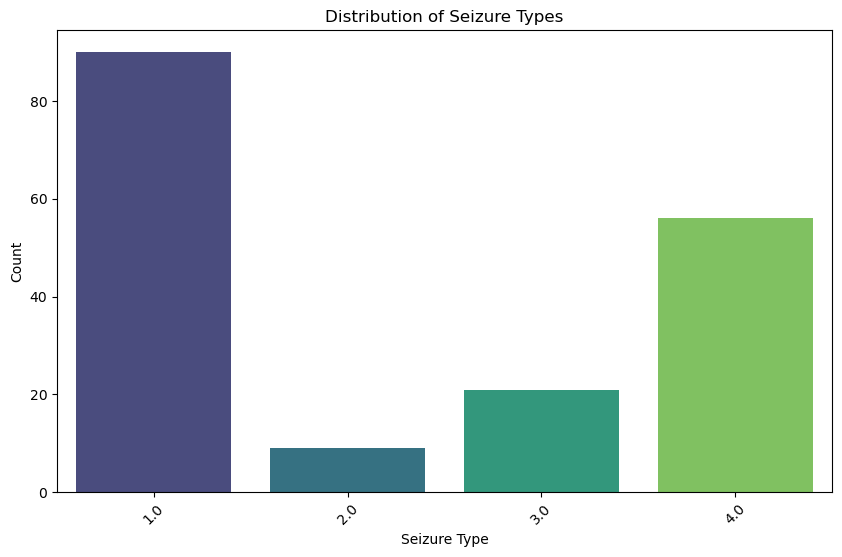

In [67]:
# Plot the distribution of different seizure types
plt.figure(figsize=(10, 6))
sns.countplot(data=df_cleaned, x='seizure_type', palette='viridis')
plt.title('Distribution of Seizure Types')
plt.xlabel('Seizure Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


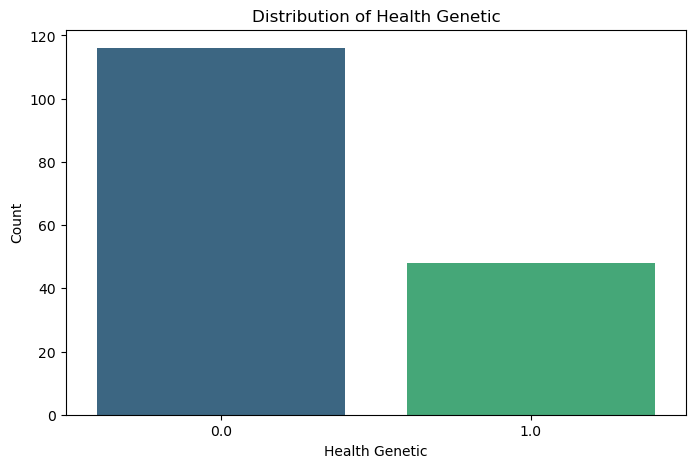

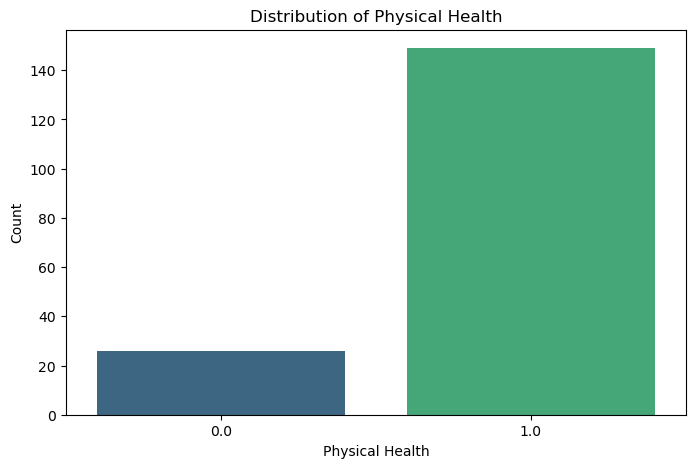

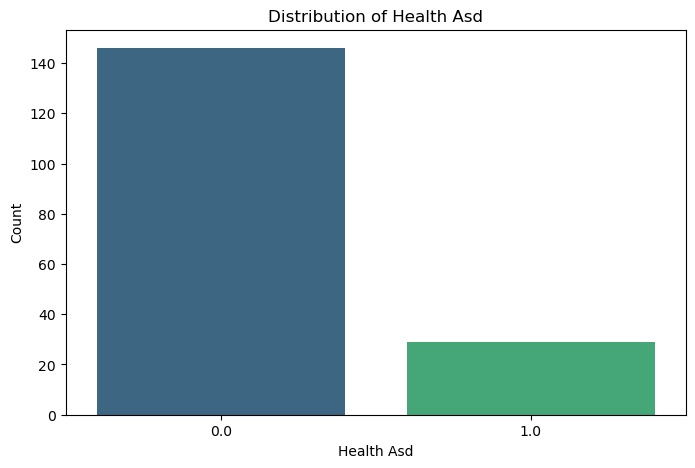

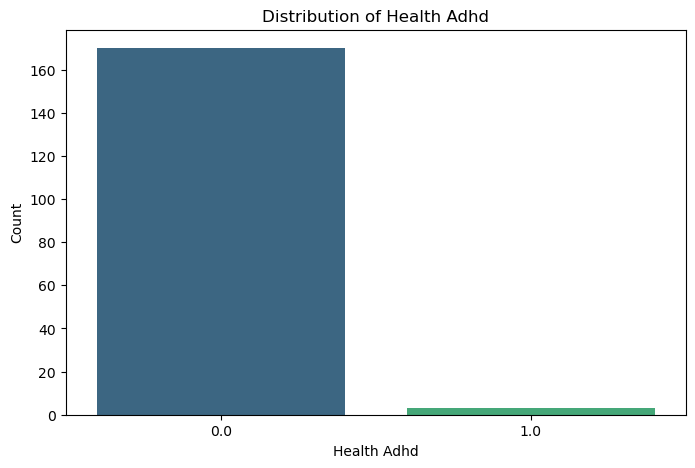

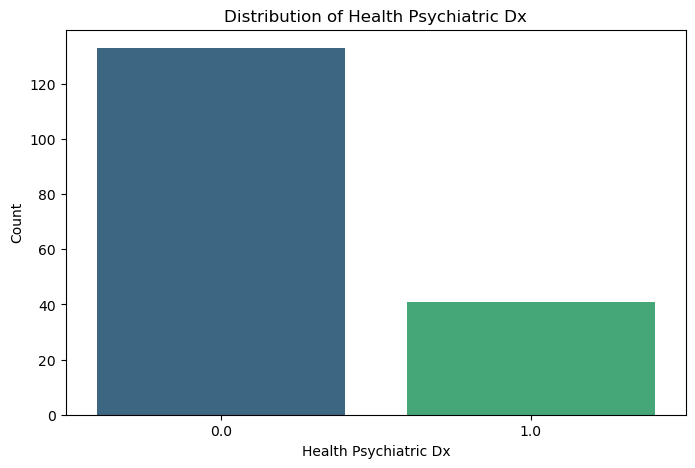

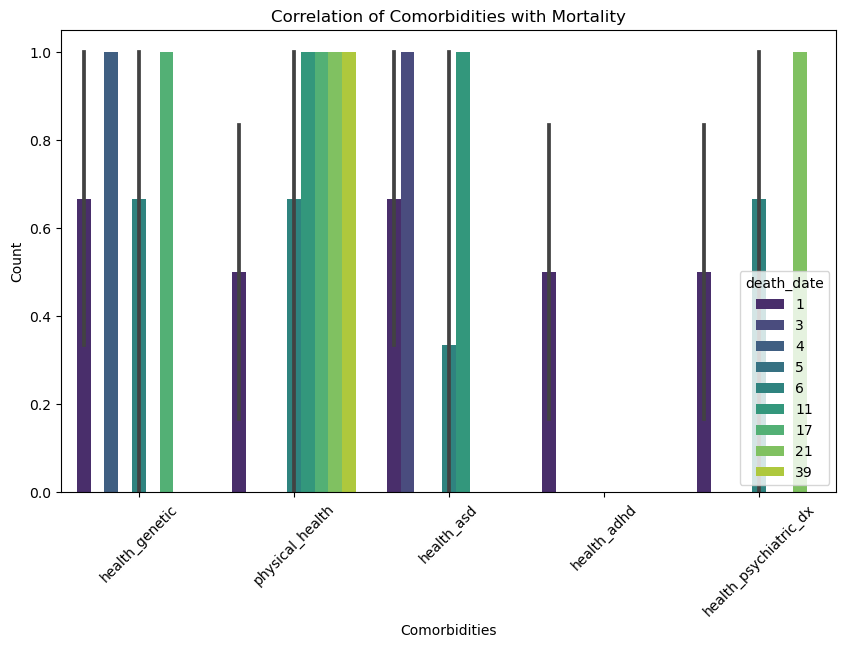

In [70]:
# Define comorbidities columns for analysis
comorbidities_columns = ['health_genetic', 'physical_health', 'health_asd', 'health_adhd', 'health_psychiatric_dx']

# Plot the distribution of each comorbidity
for condition in comorbidities_columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df_cleaned, x=condition, palette='viridis')
    plt.title(f'Distribution of {condition.replace("_", " ").title()}')
    plt.xlabel(condition.replace("_", " ").title())
    plt.ylabel('Count')
    plt.show()

# Analyze the correlation between comorbidities and mortality
comorbidities_mortality = df_cleaned.groupby(comorbidities_columns)['death_date'].count().reset_index()
comorbidities_mortality_melted = pd.melt(comorbidities_mortality, id_vars=['death_date'], value_vars=comorbidities_columns)

plt.figure(figsize=(10, 6))
sns.barplot(data=comorbidities_mortality_melted, x='variable', y='value', hue='death_date', palette='viridis')
plt.title('Correlation of Comorbidities with Mortality')
plt.xlabel('Comorbidities')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


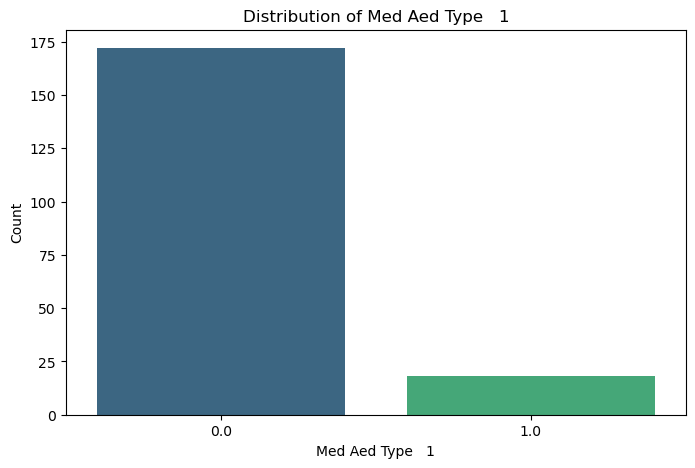

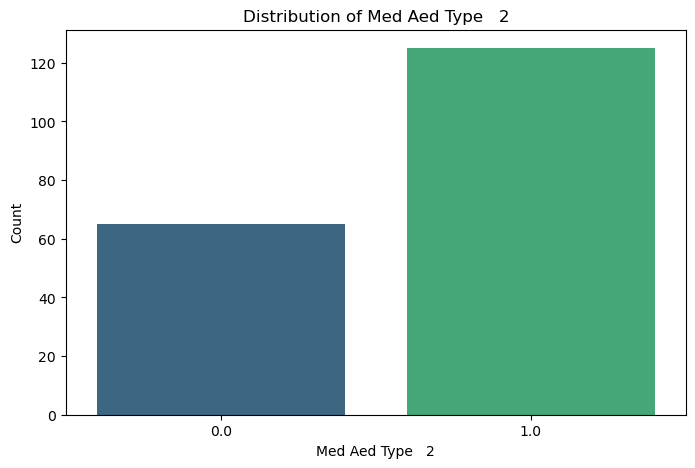

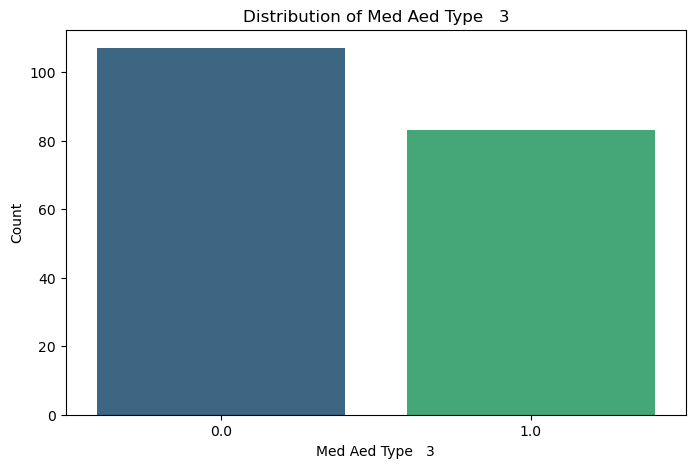

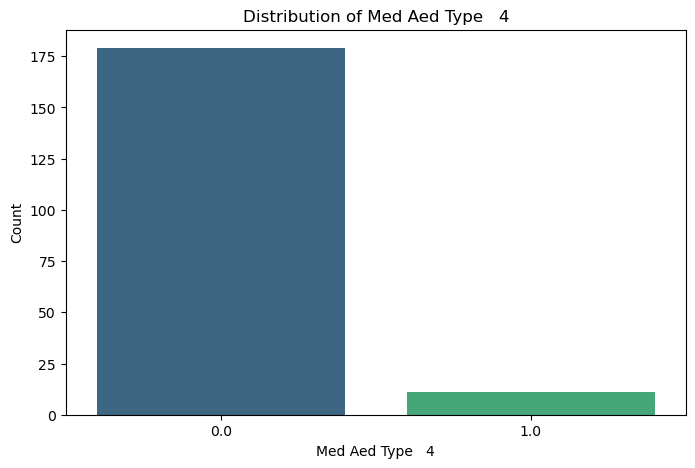

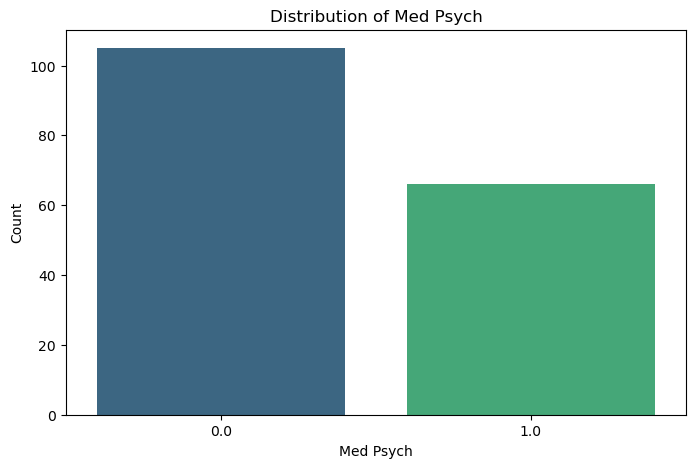

In [72]:
# Define medication columns for analysis
medication_columns = ['med_aed_type___1', 'med_aed_type___2', 'med_aed_type___3', 'med_aed_type___4', 'med_psych']

# Plot the distribution of types of medications used
for med in medication_columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df_cleaned, x=med, palette='viridis')
    plt.title(f'Distribution of {med.replace("_", " ").title()}')
    plt.xlabel(med.replace("_", " ").title())
    plt.ylabel('Count')
    plt.show()



In [44]:
##Random Forest Classifier performance
#The accuracy of 65% / ROC-AUC of 0.664835
#Model performs reasonably well
#(Moderate ability to distinguish between high and low mortality risk based on the selected features)

#Cross-Validation (0.76) indiciates a stable/reliable performance across different subsets of data


##Confusion matrix 
#Model shows a balanced distrubution of predictions
#small number of false positives/negatives

##Factor importance
#Physical health and the "checklist" Care Plan are the most significant predictors, 
#Indicates the importance of overall physical health and structured care plans in reducing mortality.

In [ ]:
##SVM model performance
#The accuracy of 60% and an ROC-AUC of 0.626374 
#Model performs reasonably well in predicting mortality based on the selected features

##Confusion matrix 
#Model correctly identifies most positive cases but has a relatively high rate of false positives

##Factor importance
#Physical health and the "checklist" Care Plan are the most significant predictors, 
#Indicates the importance of overall physical health and structured care plans in reducing mortality.

In [ ]:
#Implementing XGBoost with adjusted class weights, so that the model can better handle class imbalance and provide more accurate predictions for mortality risk

In [31]:
df

,record_id,redcap_survey_identifier,collaborator_details_timestamp,first_name,middle_name,last_name,email_address,id_service,id_service_address,collaborator_details_complete,...,checklist_surv_type,checklist_sleep_pos,checklist_a_e,checklist_compliance,checklist_aed_change,checklist_alcohol,checklist_drugs,checklist_care_plan,checklist_discussion,seizure_and_sudep_risk_factors_complete
1,7.0,NaN,20/05/2022 15:08,Lance,NaN,Watkins,lance.watkins@wales.nhs.uk,Swansea Bay UHB,Port Talbot,2.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
3,8.0,NaN,20/05/2022 15:24,Lance,NaN,Watkins,lance.watkins@wales.nhs.uk,Swansea Bay UHB,Port Talbot,2.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
5,9.0,NaN,23/05/2022 11:45,Lance,NaN,Watkins,lance.watkins@wales.nhs.uk,Swansea Bay UHB,Port Talbot,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,10.0,NaN,23/05/2022 11:55,lance,NaN,Watkins,lance.watkins@wales.nhs.uk,Swansea Bay UHB,Port Talbot,2.0,...,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,9.0,2.0
9,11.0,NaN,24/05/2022 10:56,Lance,NaN,Watkins,lance.watkins@wales.nhs.uk,Swansea Bay UHB,Port Talbot,2.0,...,Video monitor,2.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0
11,12.0,NaN,24/05/2022 11:36,lance,NaN,Watkins,lance.watkins@wales.nhs.uk,Swansea Bay UHB,Port Talbot,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,13.0,NaN,24/05/2022 11:43,Lance,NaN,Watkins,lance.watkins@wales.nhs.uk,Swansea Bay UHB,Port Talbot,2.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
15,14.0,NaN,24/05/2022 13:28,Lance,NaN,Watkins,lance.watkins@wales.nhs.uk,Swansea Bay UHB,Port Talbot,2.0,...,video monitor,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
17,15.0,NaN,24/05/2022 13:50,Lance,NaN,Watkins,lance.watkins@wales.nhs.uk,Swansea Bay UHB,Port Talbot,2.0,...,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,9.0,2.0
19,16.0,NaN,24/05/2022 14:21,Lance,NaN,Watkins,lance.watkins@wales.nhs.uk,Swansea Bay UHB,Port Talbot,2.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0


In [33]:
# Checking for missing values in each column and counting the total number of missing values
missing_values_summary = df.isna().sum()

# Filter only columns with missing values
missing_values_summary = missing_values_summary[missing_values_summary > 0]
pd.set_option('display.max_rows', None)
# Display the columns with missing values and their respective counts
missing_values_summary.to_frame(name='Missing Values Count')

,Missing Values Count
redcap_survey_identifier,190
middle_name,190
patient_death_timestamp,1
death_date,36
death_age,5
death_details,114
death_epilepsy,41
death_cause1a,34
death_cause1b,123
death_cause1c,177


In [35]:
df.describe()

,record_id,redcap_survey_identifier,middle_name,collaborator_details_complete,pt_age,pt_gender,patient_demographics_complete,death_age,death_epilepsy,patient_death_complete,...,checklist_surveillance,checklist_sleep_pos,checklist_a_e,checklist_compliance,checklist_aed_change,checklist_alcohol,checklist_drugs,checklist_care_plan,checklist_discussion,seizure_and_sudep_risk_factors_complete
count,190.000000,0.0,0.0,190.0,190.000000,190.000000,190.0,185.000000,149.000000,189.0,...,18.000000,17.000000,180.000000,149.000000,180.000000,179.000000,180.000000,125.00000,180.000000,184.0
mean,101.557895,NaN,NaN,2.0,53.373684,1.468421,2.0,53.091892,0.255034,2.0,...,1.000000,3.294118,2.972222,0.100671,2.022222,1.675978,1.705556,0.66400,4.061111,2.0
std,55.087562,NaN,NaN,0.0,16.706376,0.500320,0.0,16.537414,0.437350,0.0,...,0.485071,0.985184,4.028433,0.301908,3.634035,3.494142,3.530707,0.47424,4.250749,0.0
min,7.000000,NaN,NaN,2.0,18.000000,1.000000,2.0,18.000000,0.000000,2.0,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,2.0
25%,54.250000,NaN,NaN,2.0,39.750000,1.000000,2.0,42.000000,0.000000,2.0,...,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,2.0
50%,101.500000,NaN,NaN,2.0,57.000000,1.000000,2.0,57.000000,0.000000,2.0,...,1.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.00000,1.000000,2.0
75%,148.750000,NaN,NaN,2.0,65.000000,2.000000,2.0,65.000000,1.000000,2.0,...,1.000000,4.000000,9.000000,0.000000,1.000000,0.000000,0.000000,1.00000,9.000000,2.0
max,197.000000,NaN,NaN,2.0,86.000000,2.000000,2.0,86.000000,1.000000,2.0,...,2.000000,4.000000,9.000000,1.000000,9.000000,9.000000,9.000000,1.00000,9.000000,2.0
